In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from xgboost import XGBClassifier

from cinnamon.drift import ModelDriftExplainer, AdversarialDriftExplainer

# pandas config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed = 2021

# IEEE fraud data

Download data with kaggle CLI if it is setup on your computer:

In [5]:
#!kaggle competitions download -c ieee-fraud-detection

Else you can download the data here: https://www.kaggle.com/c/ieee-fraud-detection/data, and you will have to accept the competition rules

In [6]:
df = pd.read_csv('data/train_transaction.csv')

In [7]:
print(df.shape)

(590540, 394)


# Preprocessing

In [8]:
# count missing values per column
missing_values = df.isnull().sum(axis=0)
missing_values

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [9]:
# keep only columns with less than 10000 values
selected_columns = [col for col in df.columns if missing_values[col] < 10000]

In [10]:
# in the resulting columns, drop rows with any missing value
df = df[selected_columns].dropna(axis=0, how='any')

INFO:2022-03-30 17:50:05,131 - (/opt/anaconda3/lib/python3.8/site-packages/numexpr/utils.py) Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:2022-03-30 17:50:05,136 - (/opt/anaconda3/lib/python3.8/site-packages/numexpr/utils.py) NumExpr defaulting to 8 threads.


In [11]:
# for the variable 'card6', keep only rows corresponding to 'debit' and 'credit'modalities
df = df.loc[df['card6'].isin(['debit', 'credit']), :].copy()

In [12]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sampling

We replicate a typical production situation where we would have:
- training data
- test data
- production data

Also, we introduce so data drift on the variable `card6` by keeping only transactions which correspond to credit card. In a real application, this would correspond to the case where we are not able to identify fraud (the target label) for debit card transactions.

This data drift corresponds to a case of censoring. Generally it would correspond to concept drift.

In [13]:
# select features by keeping only numerical features
features = [col for col in df.columns if col not in ['TransactionID', 'isFraud', 'TransactionDT',
                                                     'ProductCD', 'card4', 'card6']]

In [14]:
# we do a time split (shuffle=False) to seperate between df_temp (training-test data)
# and df_prod (production data)
df_temp, df_prod = train_test_split(df.copy(), test_size=0.25, shuffle=False)

In [15]:
# the majority of transactions are made with debit cards
df_temp['card6'].value_counts()

debit     322580
credit    110956
Name: card6, dtype: int64

In [16]:
# drop all debit card transactions in train-test data
# we do a time split (shuffle=False) to seperate between train data and test data
X_train, X_test, y_train, y_test = train_test_split(df_temp.loc[df_temp['card6'].values == 'credit', features].copy(),
                                                    df_temp.loc[df_temp['card6'].values == 'credit', 'isFraud'].values,
                                                    test_size=1/3,
                                                    shuffle=False,
                                                    random_state=seed)

In [17]:
X_prod, y_prod = df_prod[features], df_prod['isFraud'].values

# Build model

In [18]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.1,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

In [19]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20,
        verbose=10, eval_metric=['auc', 'logloss'])

[0]	validation_0-auc:0.80711	validation_0-logloss:0.61547
[10]	validation_0-auc:0.85454	validation_0-logloss:0.28219
[20]	validation_0-auc:0.86206	validation_0-logloss:0.20367
[30]	validation_0-auc:0.87123	validation_0-logloss:0.18422
[40]	validation_0-auc:0.87968	validation_0-logloss:0.17869
[50]	validation_0-auc:0.88851	validation_0-logloss:0.17534
[60]	validation_0-auc:0.89127	validation_0-logloss:0.17464
[70]	validation_0-auc:0.89233	validation_0-logloss:0.17446
[80]	validation_0-auc:0.89309	validation_0-logloss:0.17445
[90]	validation_0-auc:0.89482	validation_0-logloss:0.17351
[100]	validation_0-auc:0.89476	validation_0-logloss:0.17361
[110]	validation_0-auc:0.89538	validation_0-logloss:0.17343
[112]	validation_0-auc:0.89535	validation_0-logloss:0.17349


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

# Detection of data drift

We do detect a data drift in this case. Our three indicators:

- distribution of predictions
- distribution of target labels
- performance metrics

show a data drift

In [20]:
drift_explainer = ModelDriftExplainer(clf)

In [21]:
drift_explainer.fit(X1=X_test, X2=X_prod, y1=y_test, y2=y_prod)

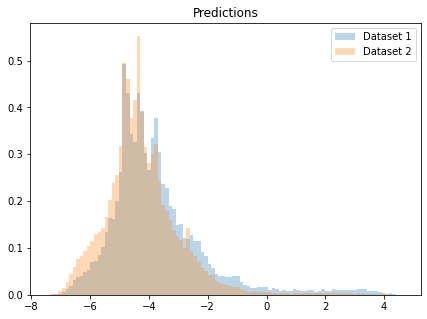

[DriftMetricsNum(mean_difference=-0.4757247830532334, wasserstein=0.4757369439221349, ks_test=BaseStatisticalTestResult(statistic=0.12358039281806144, pvalue=0.0))]

In [22]:
drift_explainer.plot_prediction_drift(figsize=(7, 5), bins=100)
drift_explainer.get_prediction_drift()

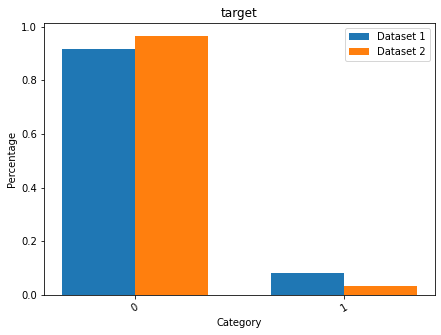

DriftMetricsCat(wasserstein=0.04893272477192796, jensen_shannon=0.07444848495091438, chi2_test=Chi2TestResult(statistic=1655.184463874216, pvalue=0.0, dof=1, contingency_table=           0       1
X1   33897.0  3089.0
X2  139514.0  4998.0))

In [23]:
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [24]:
print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test))}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

print(f'AUC test: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}')
print(f'AUC prod: {roc_auc_score(y_prod, clf.predict_proba(X_prod)[:, 1])}')

log_loss test: 0.17342663278191264
log_loss prod: 0.10822475472437297
AUC test: 0.8950968405582416
AUC prod: 0.8393885465363519


# Explain data drift

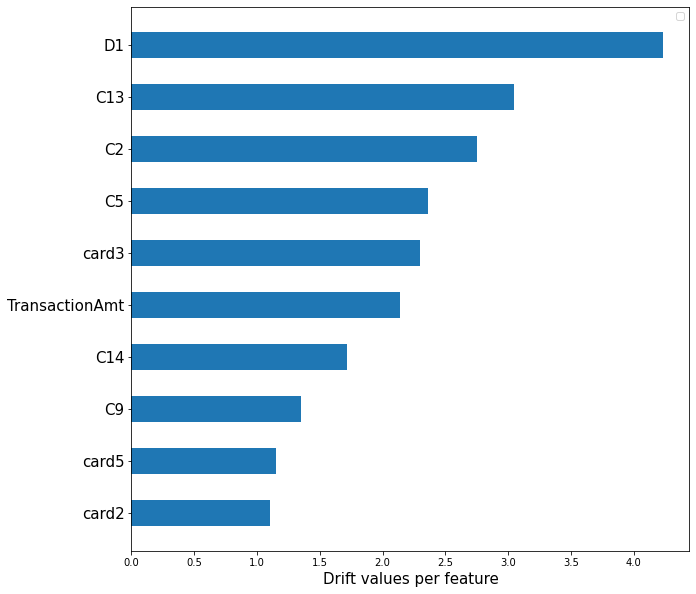

In [25]:
# plot drift values in order to identify features that have the higher impacts on data drift
drift_explainer.plot_tree_based_drift_values(type='node_size')

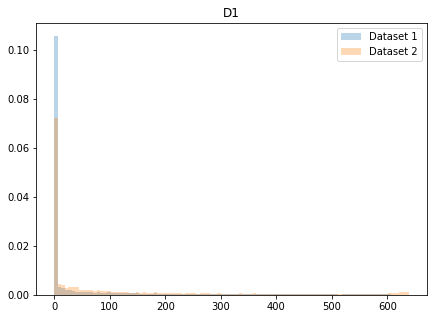

DriftMetricsNum(mean_difference=46.8838287777281, wasserstein=46.8838287777281, ks_test=BaseStatisticalTestResult(statistic=0.21429019063158317, pvalue=0.0))

In [26]:
# first drift value feature : 'D1'
drift_explainer.plot_feature_drift('D1', bins=100)
drift_explainer.get_feature_drift('D1')

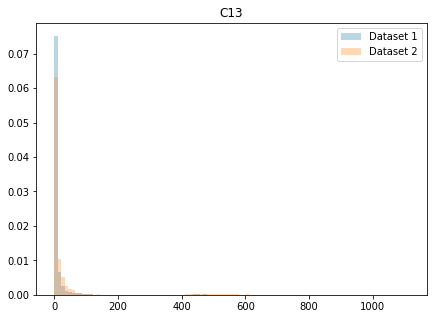

DriftMetricsNum(mean_difference=17.01094623883851, wasserstein=17.031872502765626, ks_test=BaseStatisticalTestResult(statistic=0.20382416844747753, pvalue=0.0))

In [27]:
drift_explainer.plot_feature_drift('C13', bins=100)
drift_explainer.get_feature_drift('C13')

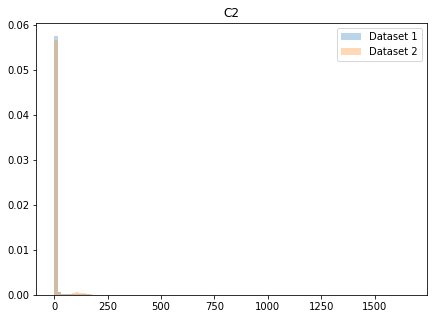

DriftMetricsNum(mean_difference=1.2646117311097331, wasserstein=2.9889224443428146, ks_test=BaseStatisticalTestResult(statistic=0.10176789237801753, pvalue=5.565022422639659e-266))

In [28]:
drift_explainer.plot_feature_drift('C2', bins=100)
drift_explainer.get_feature_drift('C2')

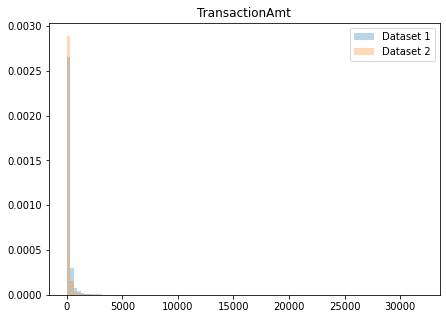

DriftMetricsNum(mean_difference=-63.08057386681716, wasserstein=63.79154259538975, ks_test=BaseStatisticalTestResult(statistic=0.1276862396004147, pvalue=0.0))

In [29]:
drift_explainer.plot_feature_drift('TransactionAmt', bins=100)
drift_explainer.get_feature_drift('TransactionAmt')

In [30]:
# feature importance of the model
pd.DataFrame(clf.feature_importances_, X_train.columns).sort_values(0, ascending=False)

,0
C7,0.143694
C14,0.036141
V317,0.035312
C1,0.034752
V295,0.029366
V312,0.026855
C13,0.024917
card3,0.023326
C2,0.020524
V314,0.019245


# Correction of data drift

## Correction on test dataset

We apply our methodology which uses adversarial learning to correct data drift between test and prod data.

We then check our three indicators of data drift in order to see if we get improvement.

In [31]:
# weights computed with the adversarial method
# feature_subset=['D1', 'C13', 'C2', 'TransactionAmt']: only the first fourth features in terms of
# drift value are selected
sample_weights_test_adversarial = (AdversarialDriftExplainer(feature_subset=['D1', 'C13'], #, 'C2', 'TransactionAmt'
                                                              seed=2021)
                                    .fit(X_test, X_prod)
                                    .get_adversarial_correction_weights(max_ratio=10))

[0]	validation_0-error:0.38811	validation_0-auc:0.63982	validation_0-logloss:0.68645
[10]	validation_0-error:0.38815	validation_0-auc:0.64349	validation_0-logloss:0.66004
[20]	validation_0-error:0.38709	validation_0-auc:0.64475	validation_0-logloss:0.65504
[30]	validation_0-error:0.38635	validation_0-auc:0.64565	validation_0-logloss:0.65399
[40]	validation_0-error:0.38571	validation_0-auc:0.64649	validation_0-logloss:0.65352
[50]	validation_0-error:0.38505	validation_0-auc:0.64659	validation_0-logloss:0.65333
[60]	validation_0-error:0.38521	validation_0-auc:0.64676	validation_0-logloss:0.65322
[70]	validation_0-error:0.38482	validation_0-auc:0.64703	validation_0-logloss:0.65316
[80]	validation_0-error:0.38488	validation_0-auc:0.64735	validation_0-logloss:0.65305
[90]	validation_0-error:0.38417	validation_0-auc:0.64787	validation_0-logloss:0.65284
[100]	validation_0-error:0.38376	validation_0-auc:0.64860	validation_0-logloss:0.65246
[110]	validation_0-error:0.38341	validation_0-auc:0.64

In [32]:
drift_explainer2 = ModelDriftExplainer(clf).fit(X1=X_test, X2=X_prod, y1=y_test, y2=y_prod,
                                                sample_weights1=sample_weights_test_adversarial)

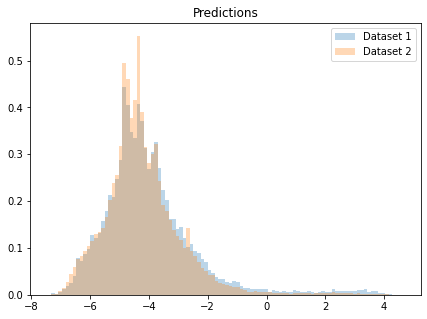

[DriftMetricsNum(mean_difference=-0.22947026956283922, wasserstein=0.22973096714192687, ks_test=BaseStatisticalTestResult(statistic=0.060302641450577954, pvalue=1.559443449372802e-93))]

In [33]:
# the drift on distribution of predictions is lowered thaks to our technique 
drift_explainer2.plot_prediction_drift(bins=100)
drift_explainer2.get_prediction_drift()

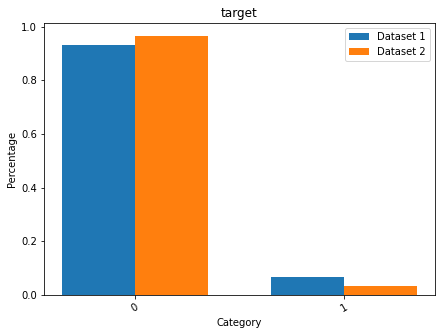

DriftMetricsCat(wasserstein=0.03176499499368591, jensen_shannon=0.051720092677320265, chi2_test=Chi2TestResult(statistic=753.889170923574, pvalue=5.724778469067358e-166, dof=1, contingency_table=                0            1
X1   34531.965654  2454.034346
X2  139514.000000  4998.000000))

In [34]:
# the target algo re-equilibrated in the good direction
drift_explainer2.plot_target_drift()
drift_explainer2.get_target_drift()

In [35]:
# valid loss is closer to prod loss, but there is still a difference
print(f'log_loss valid: {log_loss(y_test, clf.predict_proba(X_test), sample_weight=sample_weights_test_adversarial)}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

print(f'AUC valid: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1], sample_weight=sample_weights_test_adversarial)}')
print(f'AUC prod: {roc_auc_score(y_prod, clf.predict_proba(X_prod)[:, 1])}')

log_loss valid: 0.14319602526850186
log_loss prod: 0.10822475472437297
AUC valid: 0.9029484764267617
AUC prod: 0.8393885465363519


## Correction on test dataset and train dataset (in order to retrain the model)

We apply the same adversarial strategy on training data.

With the model retrain on re-weighted samples, new weights, we observe there is no obvious improvement in model performance on production data. This needs to be further investigated.

In [36]:
# weights computed with the adversarial method on training data
sample_weights_train_adversarial = (AdversarialDriftExplainer(feature_subset=['D1', 'C13', ], #'C2', 'TransactionAmt'
                                                              seed=2021)
                                    .fit(X_train, X_prod)
                                    .get_adversarial_correction_weights(max_ratio=10))

[0]	validation_0-error:0.33267	validation_0-auc:0.69947	validation_0-logloss:0.67989
[10]	validation_0-error:0.33222	validation_0-auc:0.70161	validation_0-logloss:0.62767
[20]	validation_0-error:0.33120	validation_0-auc:0.70290	validation_0-logloss:0.61860
[30]	validation_0-error:0.33096	validation_0-auc:0.70370	validation_0-logloss:0.61633
[40]	validation_0-error:0.33098	validation_0-auc:0.70453	validation_0-logloss:0.61555
[50]	validation_0-error:0.33102	validation_0-auc:0.70468	validation_0-logloss:0.61528
[60]	validation_0-error:0.33086	validation_0-auc:0.70504	validation_0-logloss:0.61479
[70]	validation_0-error:0.33095	validation_0-auc:0.70559	validation_0-logloss:0.61437
[80]	validation_0-error:0.33058	validation_0-auc:0.70597	validation_0-logloss:0.61401
[90]	validation_0-error:0.33060	validation_0-auc:0.70610	validation_0-logloss:0.61388
[100]	validation_0-error:0.33074	validation_0-auc:0.70617	validation_0-logloss:0.61383
[110]	validation_0-error:0.33070	validation_0-auc:0.70

In [37]:
clf2 = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.1,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

In [38]:
# train a new classifier with the reweighted samples
# we use a power factor 0.3 on sample_weights_train_adversarial weights to smooth them
clf2.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], sample_weight=sample_weights_train_adversarial**0.3,
         early_stopping_rounds=20, verbose=10, eval_metric=['auc', 'logloss'],
         sample_weight_eval_set=[sample_weights_test_adversarial])

[0]	validation_0-auc:0.80461	validation_0-logloss:0.61293
[10]	validation_0-auc:0.85241	validation_0-logloss:0.26732
[20]	validation_0-auc:0.85825	validation_0-logloss:0.18287
[30]	validation_0-auc:0.87415	validation_0-logloss:0.15860
[40]	validation_0-auc:0.88742	validation_0-logloss:0.15053
[50]	validation_0-auc:0.89479	validation_0-logloss:0.14717
[60]	validation_0-auc:0.89913	validation_0-logloss:0.14543
[70]	validation_0-auc:0.89999	validation_0-logloss:0.14543
[80]	validation_0-auc:0.90056	validation_0-logloss:0.14531
[90]	validation_0-auc:0.90085	validation_0-logloss:0.14507
[100]	validation_0-auc:0.90170	validation_0-logloss:0.14465
[110]	validation_0-auc:0.90147	validation_0-logloss:0.14473
[116]	validation_0-auc:0.90144	validation_0-logloss:0.14499


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [39]:
# with the reweighting, we see a small improvement for performance on production data, but is it significative ?
print(f'log_loss test: {log_loss(y_test, clf2.predict_proba(X_test), sample_weight=sample_weights_test_adversarial)}')
print(f'log_loss prod: {log_loss(y_prod, clf2.predict_proba(X_prod))}')

print(f'AUC test: {roc_auc_score(y_test, clf2.predict_proba(X_test)[:, 1], sample_weight=sample_weights_test_adversarial)}')
print(f'AUC prod: {roc_auc_score(y_prod, clf2.predict_proba(X_prod)[:, 1])}')

log_loss test: 0.1444563454765142
log_loss prod: 0.10978774974841671
AUC test: 0.9020552495064882
AUC prod: 0.8384105638470822
